<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#PlayGround" data-toc-modified-id="PlayGround-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>PlayGround</a></span></li><li><span><a href="#Main-code" data-toc-modified-id="Main-code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Main code</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test</a></span></li></ul></div>

# Main code

In [1]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFilter, ImageFont

In [2]:
from fastai.callbacks import *
from fastai.vision.gan import *

In [3]:
import os

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [4]:
path = Path("/media/subhaditya/DATA/COSMO/Datasets/shadow_gt5")
path_hr = path / "noshadow"
path_lr = path / "shadow"

In [5]:
il = ImageList.from_folder(path_hr)

In [6]:
il

ImageList (5110 items)
Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800)
Path: /media/subhaditya/DATA/COSMO/Datasets/shadow_gt5/noshadow

In [7]:
bs, size = 32, 128
# bs,size = 24,160
# bs,size = 8,256

In [8]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct()

In [9]:
def get_data(bs, size):
    data = (
        src.label_from_func(lambda x: path_hr / x.name)
        .transform(get_transforms(max_zoom=2.0), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats, do_y=True)
    )

    #     data.c = 3
    return data

In [31]:
data_gen = get_data(32, 128)

In [32]:
data_gen

ImageDataBunch;

Train: LabelList (4088 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /media/subhaditya/DATA/COSMO/Datasets/shadow_gt5/shadow;

Valid: LabelList (1022 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /media/subhaditya/DATA/COSMO/Datasets/shadow_gt5/shadow;

Test: None

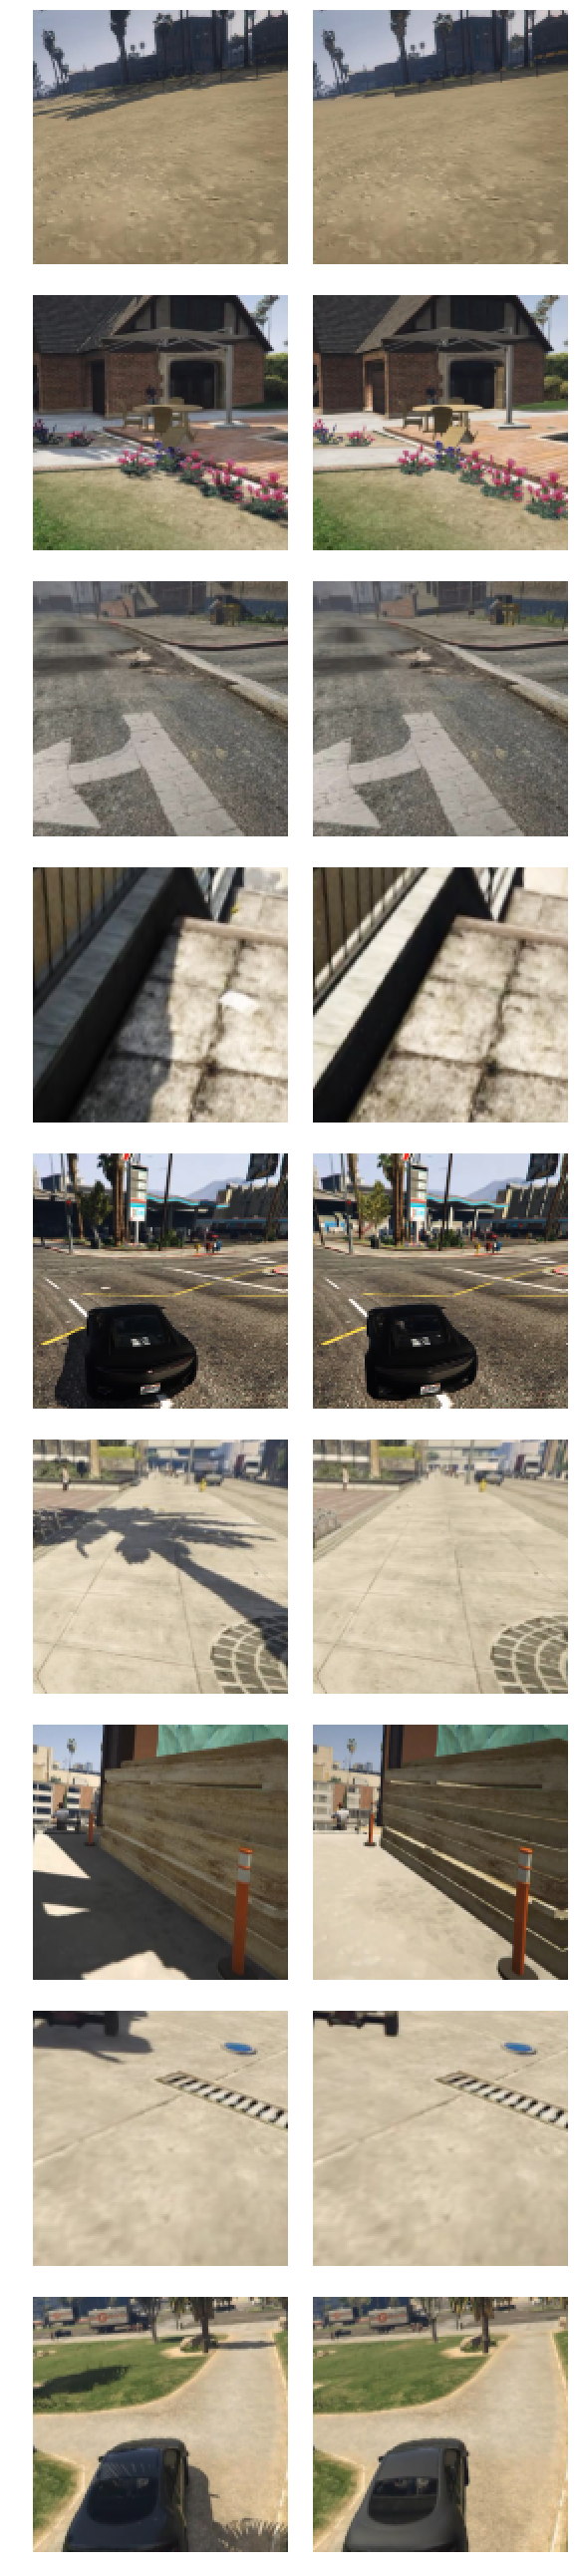

In [33]:
data_gen.show_batch(9)

In [34]:
learn_gen = None
gc.collect()

57984

# MSE

In [35]:
from torch.optim import *

In [36]:
loss = nn.L1Loss()

In [37]:
learn_gen = unet_learner(
    data_gen,
    models.resnet34,
    wd=1e-3,
    blur=True,
    norm_type=NormType.Weight,
    self_attention=False,
    #     metrics = [dice],
    callback_fns=ShowGraph,
    loss_func=loss,
    opt_func = AdamW
).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


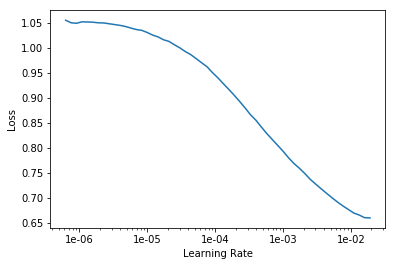

In [29]:
learn_gen.unfreeze()
learn_gen.lr_find()
learn_gen.recorder.plot()

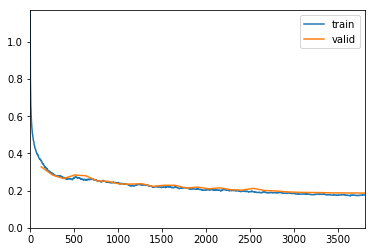

In [38]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(30, slice(1e-5,1e-2), wd=10e-3)

In [39]:
learn_gen.save("st-1-w")

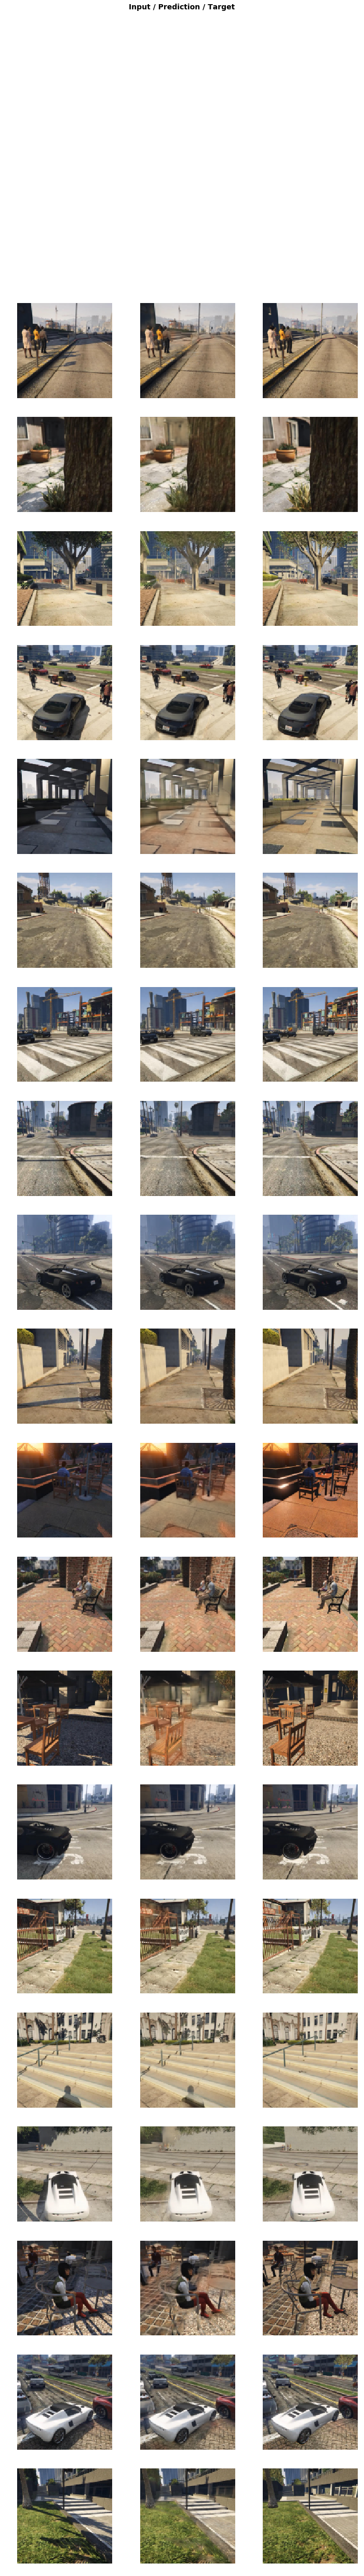

In [40]:
learn_gen.show_results(rows=20)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


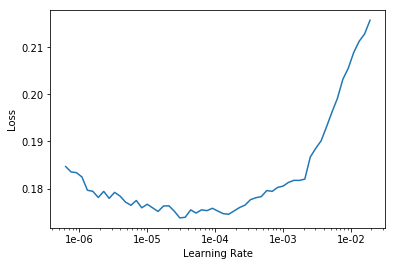

In [45]:
learn_gen.unfreeze()
learn_gen.lr_find()
learn_gen.recorder.plot()

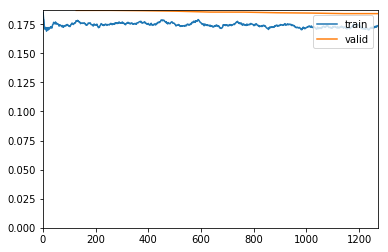

In [46]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(10, slice(1e-6, 3e-4), wd=1e-3)

In [47]:
learn_gen.save("st-2")

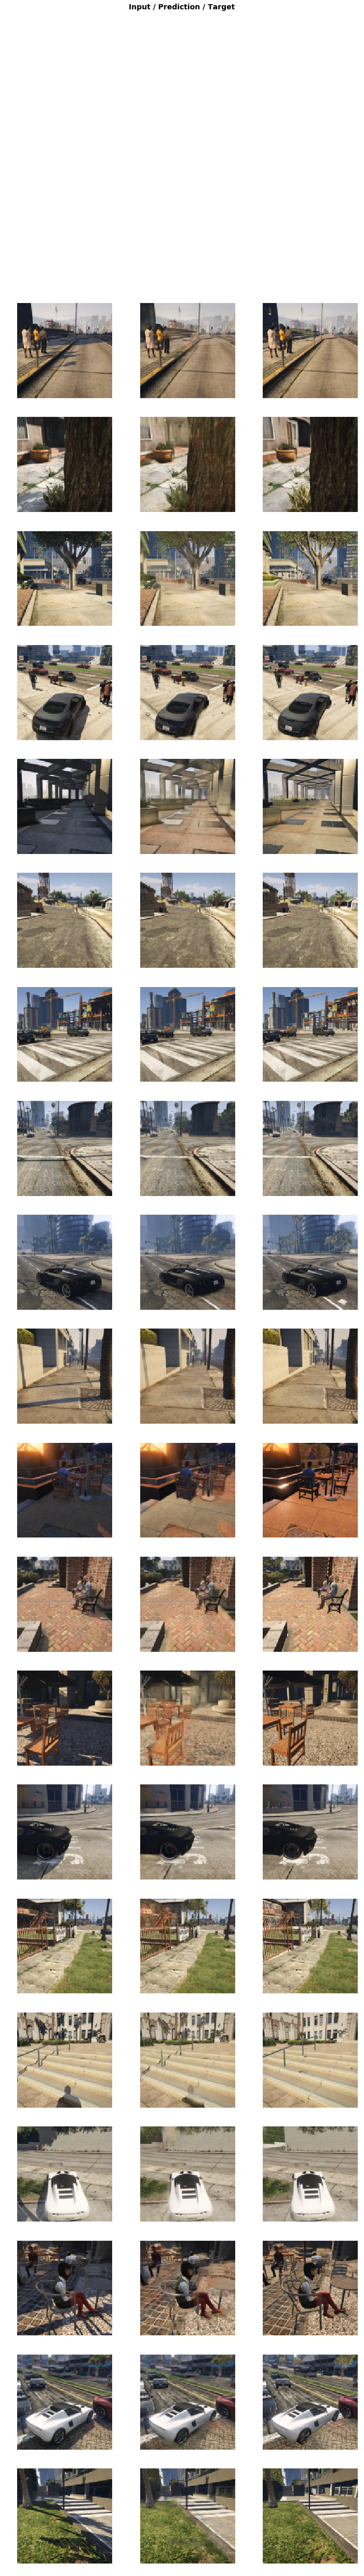

In [48]:
learn_gen.show_results(rows=20)

# Feature loss

In [1]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFilter, ImageFont

In [2]:
from fastai.callbacks import *
from fastai.vision.gan import *

In [3]:
import os

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [4]:
path = Path("/media/subhaditya/DATA/COSMO/Datasets/shadow_gt5")
path_hr = path / "noshadow"
path_lr = path / "shadow"

In [5]:
il = ImageList.from_folder(path_hr)

In [6]:
il

ImageList (5110 items)
Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800)
Path: /media/subhaditya/DATA/COSMO/Datasets/shadow_gt5/noshadow

In [7]:
bs, size = 32, 128
# bs,size = 24,160
# bs,size = 8,256

In [8]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct()

In [9]:
def get_data(bs, size):
    data = (
        src.label_from_func(lambda x: path_hr / x.name)
        .transform(get_transforms(max_zoom=2.0), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats, do_y=True)
    )

    #     data.c = 3
    return data

In [10]:
data_gen = get_data(bs, size)

In [11]:
from torch.optim import *
from torch import nn
import torch.nn.functional as F
from torchvision.models import resnet34

In [12]:
base_loss = F.l1_loss

In [13]:
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1, 2)) / (c * h * w)

In [14]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layers, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = layers
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = (
            ["pixel",]
            + [f"feat_{i}" for i in range(len(layers))]
            + [f"gram_{i}" for i in range(len(layers))]
        )

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]

    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input, target)]
        self.feat_losses += [
            base_loss(f_in, f_out) * w
            for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)
        ]
        self.feat_losses += [
            base_loss(gram_matrix(f_in), gram_matrix(f_out)) * w ** 2 * 5e3
            for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)
        ]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)

    def __del__(self):
        self.hooks.remove()

In [15]:
res_m = models.resnet34()

In [ ]:
res_m.to("cuda")

In [ ]:
requires_grad(res_m, False)
res_m.avgpool = nn.AvgPool2d(kernel_size=2, stride=1, padding=0)
res_m.fc = nn.Linear(in_features=4608, out_features=1000, bias=True)
layers = [res_m.layer2, res_m.layer3, res_m.layer4]
feat_loss = FeatureLoss(res_m, layers=layers, layer_wgts=[5, 15, 2])

In [ ]:
learn = unet_learner(
    data_gen,
    models.resnet34,
    wd=1e-3,
    loss_func=feat_loss,
    callback_fns=LossMetrics,
    blur=True,
    norm_type=NormType.Weight,
).to_fp16()

In [24]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: _thnn_conv2d_forward not supported on CPUType for Half

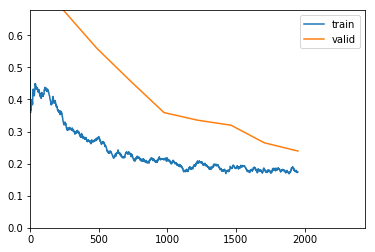

KeyboardInterrupt: 

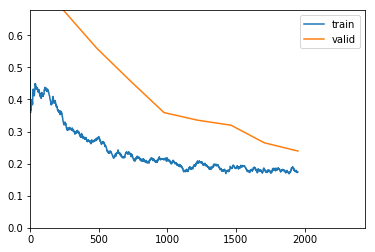

In [57]:
learn.fit_one_cycle(10, max_lr=slice(1e-6), wd=10e-4)

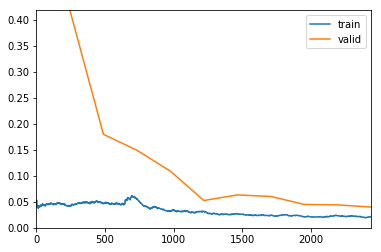

In [86]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-4), wd=1e-4)